In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# Dataset Class
class HandSignDataset(Dataset):
    def __init__(self, data_dir, img_size=(64, 64)):
        self.data_dir = data_dir
        self.image_paths = [
            img for label in range(10)
            for img in sorted(glob.glob(os.path.join(self.data_dir, str(label), '*.*')))
        ]
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = int(os.path.basename(os.path.dirname(img_path)))
        return {"image": self.transform(image), "label": label}

    def __len__(self):
        return len(self.image_paths)


In [ ]:
# Training Parameters
data_directory = '/content/drive/MyDrive/MSAI/hand_sign_classification/Hand Sign Dataset'
batch_size = 32
train_split_ratio = 0.8
img_size = (64, 64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset
dataset = HandSignDataset(data_directory, img_size=img_size)
train_size = int(train_split_ratio * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [ ]:
# Display Dataset Details
print(f"Total Dataset Size: {len(dataset)}")
print(f"Training Set Size: {len(train_set)}")
print(f"Testing Set Size: {len(test_set)}")

# Check one batch from each loader
for batch_idx, batch in enumerate(train_loader):
    train_images, train_labels = batch["image"], batch["label"]
    print("\n--- Training Batch ---")
    print(f"Batch Size: {len(train_images)}")
    print(f"Image Shape: {train_images.shape}")
    print(f"Labels: {train_labels}")
    break

for batch_idx, batch in enumerate(test_loader):
    test_images, test_labels = batch["image"], batch["label"]
    print("\n--- Testing Batch ---")
    print(f"Batch Size: {len(test_images)}")
    print(f"Image Shape: {test_images.shape}")
    print(f"Labels: {test_labels}")
    break

Total Dataset Size: 2062
Training Set Size: 1649
Testing Set Size: 413

--- Training Batch ---
Batch Size: 32
Image Shape: torch.Size([32, 3, 64, 64])
Labels: tensor([4, 0, 1, 3, 8, 4, 1, 0, 7, 8, 2, 4, 0, 8, 0, 7, 3, 0, 0, 0, 8, 0, 9, 2,
        1, 2, 8, 2, 5, 7, 0, 8])

--- Testing Batch ---
Batch Size: 32
Image Shape: torch.Size([32, 3, 64, 64])
Labels: tensor([8, 6, 2, 1, 4, 0, 1, 4, 3, 5, 4, 8, 5, 4, 8, 0, 3, 1, 3, 0, 2, 0, 1, 2,
        3, 4, 4, 1, 7, 2, 1, 5])


In [ ]:
# Flexible Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(NeuralNet, self).__init__()
        layers = []
        last_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(last_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5))  # Drop 50% of neurons
            last_size = hidden_size
        layers.append(nn.Linear(last_size, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# Model Configuration
input_dim = 3 * img_size[0] * img_size[1]
hidden_layers = [128, 64]  # Experiment with different sizes
output_classes = 10
learning_rate = 0.0003

model = NeuralNet(input_dim, hidden_layers, output_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
# Training Parameters
epochs = 100
patience = 5
best_loss = float('inf')
counter = 0

train_losses = []
val_losses = []

# Training Loop
for epoch in range(epochs):
    # Training Phase
    model.train()
    train_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device).view(batch["image"].size(0), -1)
        labels = batch["label"].to(device)

        # Forward and Backward Pass
        predictions = model(images)
        loss = loss_function(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation Phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device).view(batch["image"].size(0), -1)
            labels = batch["label"].to(device)
            predictions = model(images)
            loss = loss_function(predictions, labels)
            val_loss += loss.item()

    # Average Losses
    train_loss /= len(train_loader)
    val_loss /= len(test_loader)

    # Append losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch + 1}/{epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        print(f"Validation loss improved. Saving the model at epoch {epoch + 1}.")
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        print(f"No improvement in validation loss for {counter} epoch(s).")

    if counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break


Epoch [1/100], Training Loss: 2.2993, Validation Loss: 2.1865
Validation loss improved. Saving the model at epoch 1.
Epoch [2/100], Training Loss: 2.1798, Validation Loss: 2.0525
Validation loss improved. Saving the model at epoch 2.
Epoch [3/100], Training Loss: 2.0333, Validation Loss: 1.8504
Validation loss improved. Saving the model at epoch 3.
Epoch [4/100], Training Loss: 1.9205, Validation Loss: 1.6786
Validation loss improved. Saving the model at epoch 4.
Epoch [5/100], Training Loss: 1.7765, Validation Loss: 1.4984
Validation loss improved. Saving the model at epoch 5.
Epoch [6/100], Training Loss: 1.6901, Validation Loss: 1.4396
Validation loss improved. Saving the model at epoch 6.
Epoch [7/100], Training Loss: 1.6289, Validation Loss: 1.3383
Validation loss improved. Saving the model at epoch 7.
Epoch [8/100], Training Loss: 1.5244, Validation Loss: 1.2298
Validation loss improved. Saving the model at epoch 8.
Epoch [9/100], Training Loss: 1.4315, Validation Loss: 1.1700
Va

Loss curve saved at: loss_curve.png


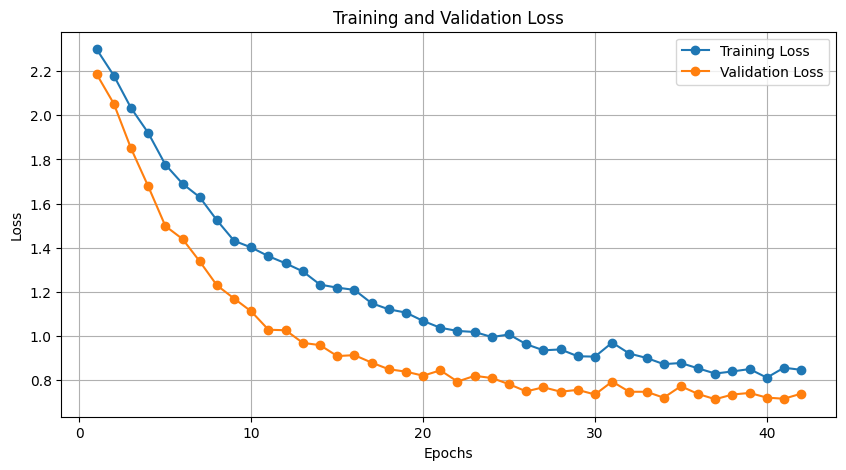

In [ ]:
# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Save the graph to a file
save_path = "loss_curve.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Loss curve saved at: {save_path}")

plt.show()


<ipython-input-44-bc8709f20e83>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Accuracy: 80.15%


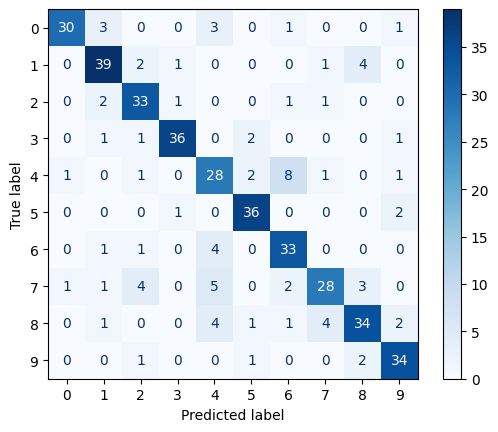

Confusion matrix saved at: test_confusion_matrix.png


In [ ]:
# Confusion Matrix Function
def plot_and_save_confusion_matrix(loader, model, save_path="confusion_matrix.png"):
    all_labels = []
    all_predictions = []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to(device).view(batch["image"].size(0), -1)
            labels = batch["label"].to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot(cmap=plt.cm.Blues)

    # Save Plot
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Confusion matrix saved at: {save_path}")

# Load Best Model and Evaluate
model.load_state_dict(torch.load("best_model.pth"))

# Test Accuracy
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device).view(batch["image"].size(0), -1)
        labels = batch["label"].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Plot Confusion Matrix
plot_and_save_confusion_matrix(test_loader, model, save_path="test_confusion_matrix.png")
